# Compute steric sea level change in the North East Atlantic using EN4 data set and gsw package

In [18]:
#import netCDF4

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
from scipy import signal
import importlib
import sys
sys.path.append('../code')
import SeaLevelContrib as slc

In [68]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '../code/SeaLevelContrib.py'>

In [43]:
data_path = '../data/DataSteric/'
data_EN4 = data_path + 'density_teos10_EN421f_analysis_g10/'
data_IAP = data_path + 'DataStericIAP/'
data_TS_IAP = data_path + 'DataTS_IAP/'
data_steric3D_IAP = data_path + 'density_teos10_IAP/'

In [75]:
def pearson_r_3D(ts,slab,anom=True):
    """
    Compute a 2D field of correlation coefficients,
    given a 1D-timeseries ('ts') and a 3D-field ('slab')
    """
    # compute anomalies if neccessary
    if not anom:
        ts = ts - np.nanmean(ts)
        slab = slab - np.expand_dims(np.nanmean(slab,axis=0),0)
    # 'ts' to match 3D shape of 'slab'
    ts_3D = np.rollaxis(np.rollaxis(np.reshape(
        np.tile(ts,slab.shape[1]*slab.shape[2]), 
        (slab.shape[2],slab.shape[1],len(ts))),2,0),2,1)
    # standard deviations
    ts_3D_slab_cov = np.nansum(ts_3D*slab,axis=0)
    ts_3D_stdev = np.sqrt(np.nansum(np.power(ts_3D,2),axis=0))
    slab_stdev = np.sqrt(np.nansum(np.power(slab,2),axis=0))
    # pearson correlation
    pearson = ts_3D_slab_cov / (ts_3D_stdev * slab_stdev)
    # done
    return pearson

### Explore the EN4 data over different integration depths and reference periods

Coordinates:
  * depth    (depth) float32 5.0215898 15.07854 25.16046 ... 5050.9897 5350.272
  * lat      (lat) float32 30.0 31.0 32.0 33.0 34.0 ... 66.0 67.0 68.0 69.0 70.0
  * lon      (lon) float32 -20.0 -19.0 -18.0 -17.0 -16.0 ... 17.0 18.0 19.0 20.0
  * time     (time) int64 1900 1901 1902 1903 1904 ... 2014 2015 2016 2017 2018


/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, '')

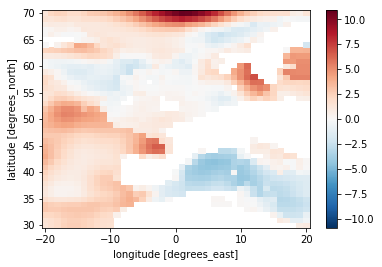

In [76]:
DENS = xr.open_dataset(data_EN4 +'density_teos10_en4_1900_2019.nc')
print(DENS.coords)
midp = (np.array(DENS.depth[1:])+np.array(DENS.depth[:-1]))/2
midp = np.insert(midp, 0, np.array([0]))
midp = np.insert(midp, len(midp), np.array(DENS.depth[-1]) + 
                 (np.array(DENS.depth[-1]) - np.array(DENS.depth[-2])))
thick = midp[1:] - midp[:-1]
thick = xr.DataArray(thick, coords={'depth': DENS.depth[:]}, dims='depth')

SumDens = DENS.density * thick
# Steric sea level in cm
StericSL = (- SumDens.sel(depth=slice(0,2000)).sum(dim='depth') 
            / DENS.density[0 ,0 ,: ,:]) * 100
StericSL = StericSL - StericSL.sel(time=slice(1940,1960)).mean(dim='time')
StericSL.sel(time=slice(2000,2018)).mean(dim='time').plot()
plt.title('')

/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nputils.py:220: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwds)


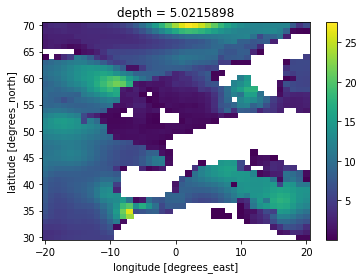

In [77]:
StericSLVar = StericSL.var(dim='time')
StericSLVar.plot()

### Check the correlation between tide gauge time series and steric sea level

In [89]:
# Read sea level data:
# Newlyn: 202, Brest: 1, Vlissingen: 20, Hoek van Holland:22
# 'NS_Fred16': [20, 32, 236, 7, 80, 89, 302, 47, 830, 361, 95, 754]
# 'ZSM' : [20, 22, 23, 24, 25, 32]
SeaLevel_df = slc.tide_gauge_obs([20, 32, 236, 7, 80, 89, 302, 47, 830, 361, 95, 754], interp = True)
SeaLevel_df.rename(columns={'Average' : 'height'}, inplace=True)

/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


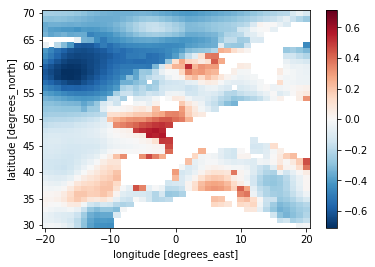

In [90]:
# Compute the correlation of the detrended data set, with a running mean of 2 years
StericSL_noNaN = xr.where(np.isnan(StericSL), 0, StericSL)
# StericSLcor_dt = pearson_r_3D( signal.detrend( SeaLevel_df.height[SeaLevel_df.index >= 1993]), 
#                            signal.detrend( StericSL_noNaN.sel( time=slice( 1993, 2017)), axis=0), anom=False)
StericSLcor_dt = pearson_r_3D( signal.detrend( SeaLevel_df.height.loc[1950:1980].rolling(2).mean().dropna() ), 
                              signal.detrend( StericSL_noNaN.sel( time=slice( 1950, 1980)).rolling(time=2).mean().dropna('time'), axis=0)
                              , anom=False)
StericSLcor_dt = xr.DataArray(StericSLcor_dt, dims=['lat', 'lon'], 
                           coords={'lat' : StericSL.lat, 'lon' : StericSL.lon})
StericSLcor_dt.plot()

The result depends a lot on the choice of the tide gauge even for the Dutch coast. Compare for example Vlissingen and Hoek van Holland.

### Define a few region masks over which the steric effect is computed

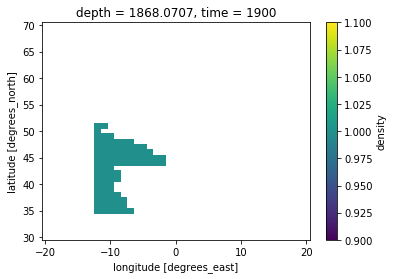

In [79]:
mask = xr.where(np.isnan(DENS.density[0,:,:,:].sel(depth=2000, method='nearest')), np.NaN, 1)
mask = mask.where(mask.lon <= -2)
mask = mask.where(mask.lon >= -12)
mask = mask.where(mask.lat <= 52)
mask = mask.where(mask.lat >= 35)
mask.plot()


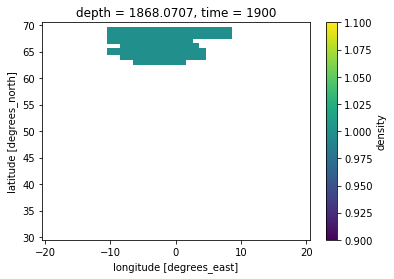

In [80]:
mask2 = xr.where(np.isnan(DENS.density[0,:,:,:].sel(depth=2000, method='nearest')), np.NaN, 1)
mask2 = mask2.where(mask2.lon <= 8)
mask2 = mask2.where(mask2.lon >= -10)
mask2 = mask2.where(mask2.lat <= 69)
mask2 = mask2.where(mask2.lat >= 60)
mask2.plot()

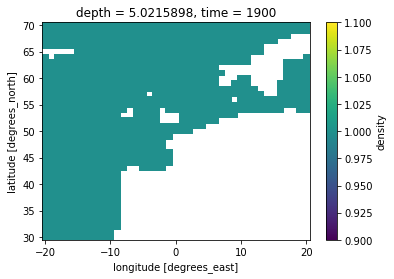

In [81]:
lat = np.array(DENS.lat)
lon = np.array(DENS.lon)
LatAr = np.repeat(lat[:,np.newaxis], len(lon), 1)
LatAr = xr.DataArray(LatAr, dims=['lat', 'lon'], 
                     coords={'lat' : lat, 'lon' : lon})
LonAr = np.repeat(lon[np.newaxis,:], len(lat), 0)
LonAr = xr.DataArray(LonAr, dims=['lat', 'lon'], 
                     coords={'lat' : lat, 'lon' : lon})

mask_med = xr.where(np.isnan(DENS.density[0,0,:,:]), np.NaN, 1)
mask_med1 = mask_med.where((LonAr >= -8) & (LatAr <= 42) )
mask_med1 = xr.where(np.isnan(mask_med1), 1, np.nan)
mask_med2 = mask_med.where((LonAr >= 1) & (LatAr <= 48) )
mask_med2 = xr.where(np.isnan(mask_med2), 1, np.nan)
mask_med = mask_med * mask_med1 * mask_med2
mask_med.plot()

#(LonAr >= 0) & (LatAr >= 60)

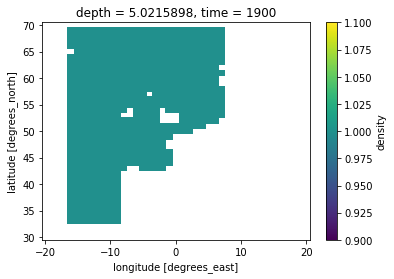

In [82]:
mask3 = xr.where(np.isnan(DENS.density[0,0,:,:]), np.NaN, 1)
mask3 = mask3.where(mask3.lon <= 7)
mask3 = mask3.where(mask3.lon >= -16)
mask3 = mask3.where(mask3.lat <= 69) #Normal value: 60
mask3 = mask3.where(mask3.lat >= 33)
mask3 = mask3 * mask_med
mask3.plot()

### Compare steric sea level in the different regions

/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


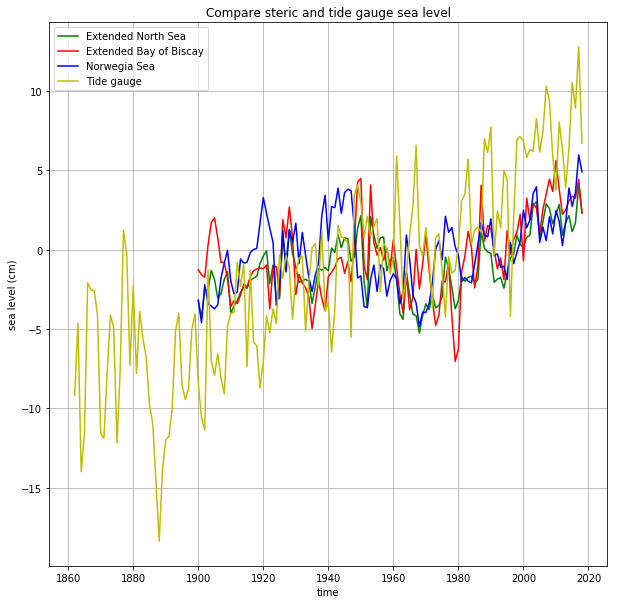

In [91]:
max_depth = 2000
StericSL_ENS_df = slc.StericSL_EN4(max_depth,'ENS')
StericSL_EBB_df = slc.StericSL_EN4(max_depth,'EBB')
StericSL_NWS_df = slc.StericSL_EN4(max_depth,'NWS')

#Plot time series
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(StericSL_ENS_df, 'g-', label='Extended North Sea')
ax.plot(StericSL_EBB_df, 'r-', label='Extended Bay of Biscay')
ax.plot(StericSL_NWS_df, 'b-', label='Norwegia Sea')
ax.plot(SeaLevel_df.height, 'y-', label='Tide gauge')

#ax.set_xlim([1993,2020])

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare steric and tide gauge sea level')
ax.grid(True)
plt.legend(loc='upper left')

### Compare with the global mean steric sea level anomaly from NOAA, Levitus

In [84]:
#Global mean total sea level anomaly (NOAA, Levitus)
LevitusSL_df = slc.LevitusSL()
LevitusSL_NA_df = slc.LevitusSL('NA')
#LevitusSL_df

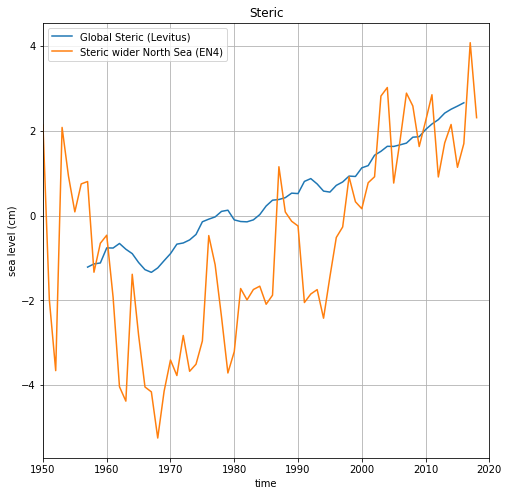

In [85]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
#ax.plot(SeaLevel_df.height, 'r-') #From mm to cm
#ax.plot(StericSL_NS_df, 'b-')
ax.plot(LevitusSL_df, label='Global Steric (Levitus)')
#ax.plot(LevitusSL_NA_df, label='North Atlantic Steric(Levitus)')
#ax.plot(StericSLreg_df, label='Steric Bay biscay (EN4)')
ax.plot(StericSL_ENS_df, label='Steric wider North Sea (EN4)')
#ax.set_aspect(1)
ax.set_xlim([1950,2020])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Steric')
plt.legend(loc='upper left')
ax.grid(True)

#plt.savefig('./Figures/ComparisonGloLocSteric', dpi=150)

### Compute the depth of the grid

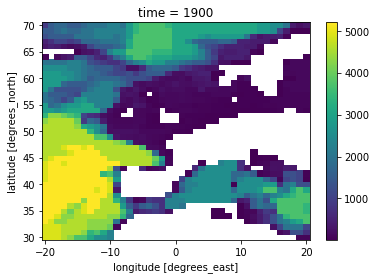

In [86]:
Ones = xr.where(np.isnan(DENS.density[0,:,:,:]), np.NaN, 1)
DepthAr = (Ones * thick).sum(axis=0)
DepthArSel = xr.where(DepthAr == 0, np.NaN, DepthAr)
DepthArSel = xr.where(DepthAr >= 6000, np.NaN, DepthArSel)
DepthArSel.plot()
#DepthAr.plot()

Idea: Use the same method as in Seltini et al. 2017? Average steric effect of deeper area to determine the local effect. For "surface" waters. Use a large area for deep water and an even larger area for bottom water.

### Compare Levitus pentad data that stop in 2016 with the yearly data that goes on to 2018

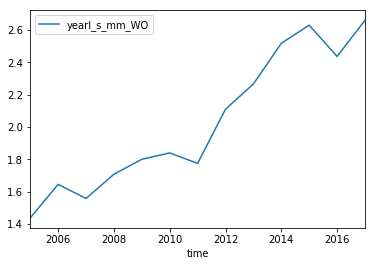

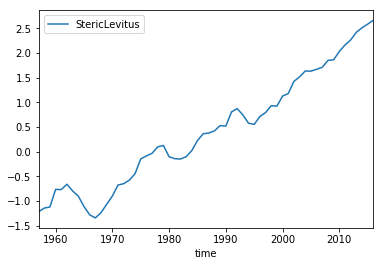

In [87]:
PATH_Data = '/Users/dewilebars/Data/'
Dir_LEV = PATH_Data + 'NOAA/'

Lev_ds = xr.open_dataset(Dir_LEV + \
                         'mean_total_steric_sea_level_anomaly_0-2000_yearly.nc', \
                         decode_times=False)
LevitusSL_y = Lev_ds.yearl_s_mm_WO.copy() / 10

# Convert from months since 1955 to years
LevitusSL_y['time'] = LevitusSL_y.time / 12 + 1955 - .5
LevitusSL_y['time'] = LevitusSL_y.time.astype(int)
LevitusSL_y_df = LevitusSL_y.to_dataframe()
LevitusSL_y_df.iloc[:-1].plot()
LevitusSL_df.plot()

Conclusion: The yearly data only adds one year so it is not worth it.

### Explore steric sea level from Cheng et al. 2017

In [5]:
# Read data preprocessed by DensityIAP_month2year.py
IAP_ds = xr.open_dataset(data_IAP+'Steric_IAP_2000m_yearly_1940_2019.nc')
IAP_ds

<xarray.Dataset>
Dimensions:    (depth_std: 41, lat: 180, lon: 360, time: 80)
Coordinates:
  * lat        (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * depth_std  (depth_std) float32 1.0 5.0 10.0 20.0 ... 1700.0 1800.0 2000.0
  * time       (time) int64 1940 1941 1942 1943 1944 ... 2016 2017 2018 2019
Data variables:
    SSL_2000m  (time, lat, lon) float32 ...
    SSL_1500m  (time, lat, lon) float32 ...
    SSL_700m   (time, lat, lon) float32 ...
    SSL_300m   (time, lat, lon) float32 ...
    SSL_100m   (time, lat, lon) float32 ...

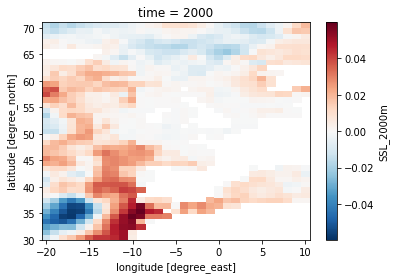

In [7]:
IAP_ds.SSL_2000m.sel(time=2000,lat=slice(30.5,70.5),lon=slice(-20,10)).plot()

It is not possible to have the same method as used in EN4 with the steric data provided by IAP. For EN4 I downloaded the salinity and temperature fields and then computed the 3D steric expansion at each vertical level. This allowed to average steric sea level over larger areas.

It would be more consistent to do the same here with the IAP data. It also gives me a better handle on the exact way the expansion is computed.

In the meantime the Extended Bay of Biscay and Norwegian Sea regions can be used.

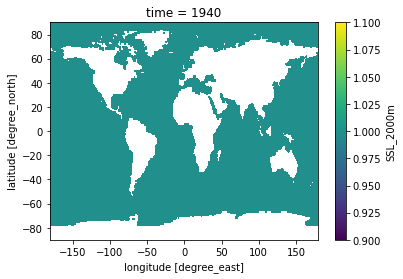

In [10]:
mask = xr.where(np.isnan(IAP_ds.SSL_2000m[0,:,:]), np.nan, 1)
mask.plot()

In [28]:
def steric_masks_IAP2D(da, mask_name):
    if mask_name == 'ENS':
        # Extended North Sea mask
        lat = np.array(da.lat)
        lon = np.array(da.lon)
        LatAr = np.repeat(lat[:,np.newaxis], len(lon), 1)
        LatAr = xr.DataArray(LatAr, dims=['lat', 'lon'], 
                             coords={'lat' : lat, 'lon' : lon})
        LonAr = np.repeat(lon[np.newaxis,:], len(lat), 0)
        LonAr = xr.DataArray(LonAr, dims=['lat', 'lon'], 
                             coords={'lat' : lat, 'lon' : lon})

        mask_med = xr.where(np.isnan(da[0,:,:]), np.nan, 1)
        mask_med1 = mask_med.where((LonAr >= -8) & (LatAr <= 42) )
        mask_med1 = xr.where(np.isnan(mask_med1), 1, np.nan)
        mask_med2 = mask_med.where((LonAr >= 1) & (LatAr <= 48) )
        mask_med2 = xr.where(np.isnan(mask_med2), 1, np.nan)
        mask_med = mask_med * mask_med1 * mask_med2

        mask = xr.where(np.isnan(da[0,:,:]), np.nan, 1)
        mask = mask.where(mask.lon <= 7)
        mask = mask.where(mask.lon >= -16)
        mask = mask.where(mask.lat <= 69) #Normal value: 60 or 69
        mask = mask.where(mask.lat >= 33)
        mask = mask * mask_med
    del mask['time']
    return mask

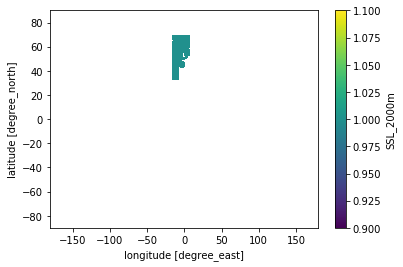

In [30]:
mask_ENS = steric_masks_IAP2D(IAP_ds.SSL_2000m, 'ENS')
mask_ENS.plot()

### Look into the 3D density files computed from IAP (Cheng et al. 2017)

In [56]:
steric3D_IAP = xr.open_mfdataset(data_steric3D_IAP+'density_teos10_iap_*.nc')

In [66]:
steric3D_IAP.depth

<xarray.DataArray 'depth' (depth: 41)>
array([1.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, 3.0e+01, 4.0e+01, 5.0e+01, 6.0e+01,
       7.0e+01, 8.0e+01, 9.0e+01, 1.0e+02, 1.2e+02, 1.4e+02, 1.6e+02, 1.8e+02,
       2.0e+02, 2.5e+02, 3.0e+02, 3.5e+02, 4.0e+02, 4.5e+02, 5.0e+02, 5.5e+02,
       6.0e+02, 6.5e+02, 7.0e+02, 7.5e+02, 8.0e+02, 8.5e+02, 9.0e+02, 1.0e+03,
       1.1e+03, 1.2e+03, 1.3e+03, 1.4e+03, 1.5e+03, 1.6e+03, 1.7e+03, 1.8e+03,
       2.0e+03], dtype=float32)
Coordinates:
  * depth    (depth) float32 1.0 5.0 10.0 20.0 ... 1600.0 1700.0 1800.0 2000.0
Attributes:
    long_name:      standard depth
    units:          m
    standard_name:  depth_std

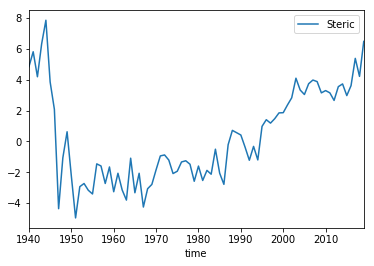

In [71]:
steric_ENS_IAP = slc.StericSL(2000, 'ENS', 'IAP')
steric_ENS_IAP.plot()

### Compare steric sea level from IAP and from EN4

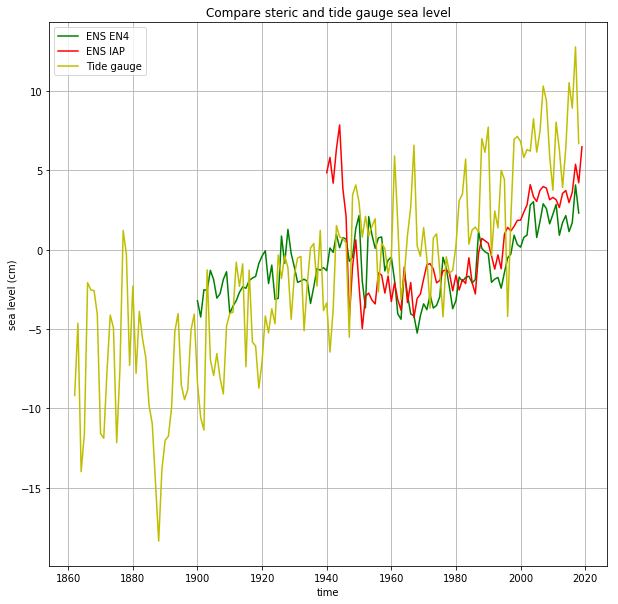

In [92]:
#Plot time series
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(StericSL_ENS_df, 'g-', label='ENS EN4')
ax.plot(steric_ENS_IAP, 'r-', label='ENS IAP')
ax.plot(SeaLevel_df.height, 'y-', label='Tide gauge')
#ax.set_xlim([1993,2020])

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare steric and tide gauge sea level')
ax.grid(True)
plt.legend(loc='upper left')

The IAP data has a strange drop of steric sea level in the 1940s. This drop is not found in the data nor in EN4.